# Практическое задание у уроку 6

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
import os

AUTOTUNE = tf.data.experimental.AUTOTUNE

Using TensorFlow backend.


In [2]:
train_path_=str('E:\\carnava\\train\\')
train_mask_path_=str('E:\\carnava\\train_masks\\')
path_mask_csv=str('E:\carnava\train_masks.csv')

In [3]:
def list_files(path_ds):
    list_=[]
    for file_name in os.listdir(path_ds):
        list_.append(f'{path_ds}{file_name}')
    return list_

In [4]:
split_index=20
all_image_paths=list_files(train_path_)
all_image_mask=list_files(train_mask_path_)



In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [7]:
def preprocess_image(image,channels=3):
  image = tf.image.decode_jpeg(image, channels=channels)
  image = tf.image.resize(image, [128, 128])
  image /= 255.0  # normalize to [0,1] range

  return image

In [8]:
def preprocess_mask(image):
  image = tf.image.decode_jpeg(image)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.resize(image, [128, 128])
  image /= 255.0  # normalize to [0,1] range
  
  return image

In [9]:
def load_and_preprocess_image(path,channels=3):
  image = tf.io.read_file(path)
  return preprocess_image(image,channels)

In [10]:
def load_and_preprocess_mask(path,channels=0):
  image = tf.io.read_file(path)
  return preprocess_mask(image)

In [33]:
def split_train_test(all_image_paths,all_image_mask,split_index=20):
    train_path=all_image_paths[:-split_index]
    train_path_mask=all_image_mask[:-split_index]
    test_path=all_image_paths[-split_index:]
    test_path_mask=all_image_mask[-split_index:]
    path_train = tf.data.Dataset.from_tensor_slices(train_path)
    path_train_mask = tf.data.Dataset.from_tensor_slices(train_path_mask)
    path_test = tf.data.Dataset.from_tensor_slices(test_path)
    path_test_mask = tf.data.Dataset.from_tensor_slices(test_path_mask)
    
    train_ds = path_train.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    train_mask_ds=path_train_mask.map(load_and_preprocess_mask, num_parallel_calls=AUTOTUNE)
    
    test_ds = path_test.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    test_mask_ds=path_test_mask.map(load_and_preprocess_mask, num_parallel_calls=AUTOTUNE)
    
    return tf.data.Dataset.zip((train_ds, train_mask_ds)), tf.data.Dataset.zip((test_ds, test_mask_ds))    

In [34]:
train, test=split_train_test(all_image_paths,all_image_mask)


In [35]:
image_count=len(all_image_paths)-20
test_size=20

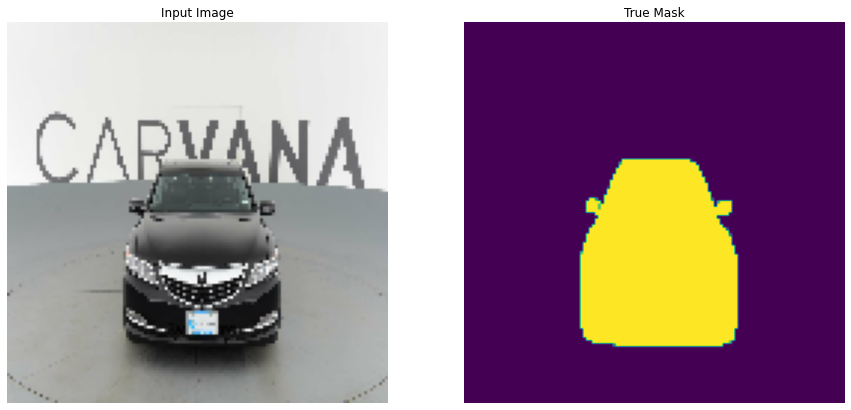

In [37]:
for image, mask in train.take(1):
      sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

In [15]:
BATCH_SIZE = 32
buffer_size=image_count

# Установка размера буфера перемешивания, равного набору данных, гарантирует
# полное перемешивание данных.
train = train.shuffle(buffer_size=buffer_size)
train = train.repeat()
train = train.batch(BATCH_SIZE)
# `prefetch` позволяет датасету извлекать пакеты в фоновом режиме, во время обучения модели.
train = train.prefetch(buffer_size=AUTOTUNE)


In [16]:
test = test.repeat()
test = test.batch(BATCH_SIZE)
# `prefetch` позволяет датасету извлекать пакеты в фоновом режиме, во время обучения модели.
test = test.prefetch(buffer_size=AUTOTUNE)

In [17]:
#ds = image_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=buffer_size))
#ds = ds.batch(BATCH_SIZE)
#ds = ds.prefetch(buffer_size=AUTOTUNE)
#ds

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand',   # 64x64
    'block_3_expand',   # 32x32
    'block_6_expand',   # 16x16
    'block_13_expand',  # 8x8
  #  'block_13_depthwise',
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [19]:
up_stack = [
   pix2pix.upsample(512, 3),  # 4x4 -> 8x8
   
   pix2pix.upsample(256, 3),  # 8x8 -> 16x16
 
   pix2pix.upsample(128, 3),  # 16x16 -> 32x32 
 
   pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
OUTPUT_CHANNELS = 3
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
TRAIN_LENGTH = image_count
BATCH_SIZE = 32
BUFFER_SIZE = image_count
STEPS_PER_EPOCH =  TRAIN_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH

158

In [23]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1):
 
    display([sample_image, sample_mask,
    create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

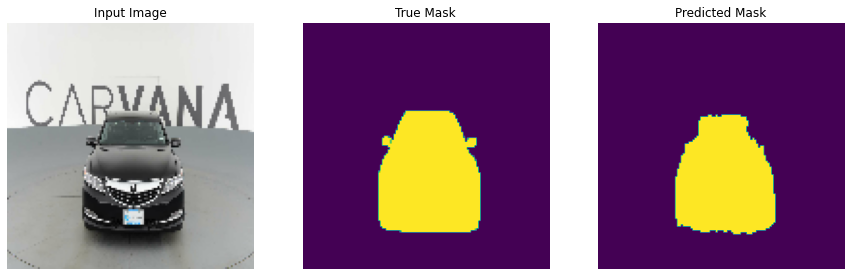


Sample Prediction after epoch 5

158/158 [==============================] - 273s 2s/step - loss: 0.0170 - accuracy: 0.9924 - val_loss: 0.0672 - val_accuracy: 0.9753


In [30]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 10#test_size//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

### Вывод: датасет Carvana архитектура U-Net оставлена почти без изменений (изменены только блоки слоев) высокая точность на тестовой выборки связана с определением маски(при абрисе точность будет ниже) увеличение количество эпох добавит точность. архитектура декодера соблюдения размерности входных данных блоков кодировщика